In [1]:
import numpy as np
import pandas as pd

from Replayers import ABTestReplayer, EpsilonGreedyReplayer, ThompsonSamplingReplayer

# Load historical data

In [5]:
rating_df = pd.read_csv('data/top-n-movies_user-ratings.csv').drop(columns='Unnamed: 0')
rating_df.head()

,user_id,movie_id,rating,movie_title
0,307,0,4,Toy Story
1,250,99,4,Fargo
2,24,180,5,Return of the Jedi
3,19,287,1,Scream
4,31,293,3,Liar Liar


## Translate ratings into a binary reward value

In [6]:
reward_threshold = 4
rating_df['reward'] = rating_df.eval('rating > @reward_threshold').astype(int)
rating_df.head()

,user_id,movie_id,rating,movie_title,reward
0,307,0,4,Toy Story,0
1,250,99,4,Fargo,0
2,24,180,5,Return of the Jedi,1
3,19,287,1,Scream,0
4,31,293,3,Liar Liar,0


# Set the parameters for the simulations

In [7]:
n_visits = 20000
n_iterations = 20

reward_history = rating_df
item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'reward'

# A/B Test Simulations

## Test period = 1,000 visits

### Run the test

In [8]:
n_test_visits = 1000
ab_1k_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

100%|██████████| 20/20 [22:49<00:00, 68.48s/it]


In [10]:
ab_1k_results_df = pd.DataFrame(ab_1k_results)
ab_1k_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,1.000000,120,0,1,1,0,12
1,0.500000,299,0,0,1,1,783
2,0.666667,49,0,1,2,2,649
3,0.750000,49,0,1,3,3,837
4,0.800000,49,0,1,4,4,483


### Save the output

In [11]:
ab_1k_results_df.to_csv('output/ab_test_1k.csv')

## Test period = 5,000 visits

### Run the test

In [12]:
n_test_visits = 5000
ab_5k_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                               item_col_name, visitor_col_name, reward_col_name,
                               n_iterations=n_iterations).replay()

100%|██████████| 20/20 [20:43<00:00, 62.19s/it]


In [13]:
ab_5k_results_df = pd.DataFrame(ab_5k_results)
ab_5k_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,1.000000,120,0,1,1,0,12
1,0.500000,299,0,0,1,1,783
2,0.666667,49,0,1,2,2,649
3,0.750000,49,0,1,3,3,837
4,0.800000,49,0,1,4,4,483


### Save the output

In [14]:
ab_5k_results_df.to_csv('output/ab_test_5k.csv')

# $\epsilon$-Greedy Simulations

## $\epsilon$ = 0.05

### Run the test

In [15]:
epsilon = 0.05
epsilon_05_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

100%|██████████| 20/20 [19:02<00:00, 57.15s/it]


In [16]:
epsilon_05_results_df = pd.DataFrame(epsilon_05_results)
epsilon_05_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,0.0,0,0,0,0,0,12
1,0.0,257,0,0,0,1,58
2,0.0,0,0,0,0,2,222
3,0.0,0,0,0,0,3,830
4,0.2,0,0,1,1,4,313


### Save the output

In [17]:
epsilon_05_results_df.to_csv('output/epsilon_greedy_05.csv')

## $\epsilon$ = 0.10

### Run the test

In [18]:
epsilon = 0.10
epsilon_10_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,
                                           n_iterations=n_iterations).replay()

100%|██████████| 20/20 [20:21<00:00, 61.07s/it]


In [19]:
epsilon_10_results_df = pd.DataFrame(epsilon_10_results)
epsilon_10_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,0.0,0,0,0,0,0,12
1,0.0,257,0,0,0,1,58
2,0.0,0,0,0,0,2,222
3,0.0,0,0,0,0,3,830
4,0.2,0,0,1,1,4,313


### Save the output

In [20]:
epsilon_10_results_df.to_csv('output/epsilon_greedy_10.csv')

# Thompson Sampling Simulations

### Run the test

In [33]:
thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()

100%|██████████| 20/20 [21:45<00:00, 65.28s/it]


In [34]:
thompson_results_df = pd.DataFrame(thompson_results)
thompson_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,0.000000,299,0,0,0,0,12
1,0.500000,49,0,1,1,1,333
2,0.666667,49,0,1,2,2,693
3,0.500000,49,0,0,2,3,479
4,0.400000,120,0,0,2,4,525


### Save the output

In [35]:
thompson_results_df.to_csv('output/thompson_sampling.csv')

# Compare the results

## Average the results across all runs

In [36]:
ab_1k_avg_results_df = ab_1k_results_df.groupby('visit', as_index=False).mean()

ab_5k_avg_results_df = ab_5k_results_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_df = epsilon_05_results_df.groupby('visit', as_index=False).mean()

epsilon_10_avg_results_df = epsilon_10_results_df.groupby('visit', as_index=False).mean()

thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

## Plot the output

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [38]:
sns.set(font_scale=2.5)

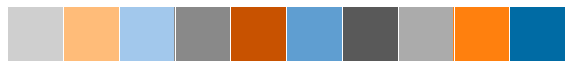

In [39]:
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

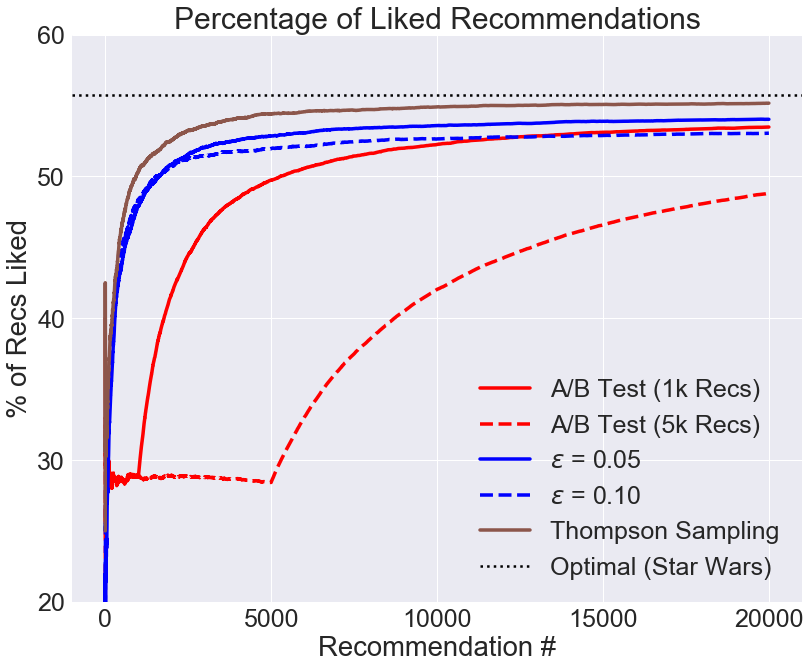

In [40]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ab_1k_avg_results_df, 'r-'),
                                (ab_5k_avg_results_df, 'r--'),
                                (epsilon_05_avg_results_df, 'b-'),
                                (epsilon_10_avg_results_df, 'b--'),
                                (thompson_avg_results_df, 'tab:brown')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)

# add a line for the optimal value -- 0.5575 for Star Wars (from exploration noteboook)
ax.axhline(y=0.5575, color='k', linestyle=':', linewidth=2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0,22000,5000))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['A/B Test (1k Recs)',
           'A/B Test (5k Recs)',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10',
           'Thompson Sampling',
           'Optimal (Star Wars)'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()